# Prepoznavanje Emocija Pomoću ResNet50 Modela

## Projekat iz Računarske Inteligencije

Ovaj notebook predstavlja demonstraciju implementacije i rezultata ResNet50 modela za prepoznavanje emocija. Fokus je na optimizaciji modela za rad sa nebalansiranim klasama koristeći focal loss i class weights.

## Uvod

### Ključni Aspekti Projekta:
- Implementacija ResNet50 arhitekture sa transfer learning-om
- Rešavanje problema nebalansiranih klasa
- Optimizacija hiperparametara
- Evaluacija na test skupu podataka

### Organizacija Koda:
- Glavni kod je organizovan u Python modulima
- Notebook služi za demonstraciju i vizualizaciju rezultata
- Fokus je na jasnoj prezentaciji ključnih koncepata

In [17]:
# Importovanje potrebnih biblioteka
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Importovanje našeg modula
import sys
sys.path.append('.')  # dodajemo trenutni direktorijum u python path
from src import train_resnet

# Postavka za lepši prikaz grafika
plt.style.use('default')  # prvo postavljamo default stil
sns.set_theme()  # zatim primenjujemo seaborn temu
sns.set_palette("husl")  # i na kraju postavljamo paletu

## Arhitektura Modela

Naš model je zasnovan na ResNet50 arhitekturi sa sledećim modifikacijama:
- Transfer learning sa težinama pretreniranim na ImageNet datasetu
- Prilagođeni gornji slojevi za klasifikaciju emocija
- Implementacija focal loss funkcije
- Optimizovani težinski faktori za klase

In [18]:
# Učitavanje najbolje istreniranog modela
models_dir = Path("models")

# Učitavanje modela
model_path = models_dir / "final_model_resnet.keras"
if not model_path.exists():
    raise FileNotFoundError("Nije pronađen model: models/final_model_resnet.keras")

print(f"Učitavanje modela iz: {model_path}")

# Kreiranje modela
model, base = train_resnet.build_resnet_model(
    input_shape=(*train_resnet.CONFIG["image_size"], 3),
    num_classes=train_resnet.CONFIG["num_classes"]
)

# Kompajliranje modela
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Učitavanje naših treniranih težina
model.load_weights(str(model_path))

# Prikaz broja parametara
trainable_count = sum([tf.size(w) for w in model.trainable_weights])
total_count = sum([tf.size(w) for w in model.weights])
print(f'Trenabilni parametri: {trainable_count:,}')
print(f'Ukupno parametara: {total_count:,}')

Učitavanje modela iz: models/final_model_resnet.keras
Trenabilni parametri: 530,439
Ukupno parametara: 24,122,247
Trenabilni parametri: 530,439
Ukupno parametara: 24,122,247


/Users/vvm/Desktop/уник/не_мтуси/предметы/6_sem/RI/project/RI-Project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Analiza Rezultata

Pogledajmo detaljnu analizu performansi našeg ResNet50 modela na validacionom skupu podataka. Posebno ćemo se fokusirati na:
- Metrike po klasama
- Matricu konfuzije
- Prosečnu pouzdanost predviđanja

Dataset is already downloaded
Found 12271 files belonging to 7 classes.
Found 12271 files belonging to 7 classes.
Using 10431 files for training.
Using 10431 files for training.
Found 12271 files belonging to 7 classes.
Found 12271 files belonging to 7 classes.
Using 1840 files for validation.
Using 1840 files for validation.
Found 3068 files belonging to 7 classes.
Found 3068 files belonging to 7 classes.
Dataset is already downloaded
Dataset is already downloaded
Found 28709 files belonging to 7 classes.
Found 28709 files belonging to 7 classes.
Using 24403 files for training.
Using 24403 files for training.
Found 28709 files belonging to 7 classes.
Found 28709 files belonging to 7 classes.
Using 4306 files for validation.
Using 4306 files for validation.
Found 7178 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


2025-10-18 07:01:42.983995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


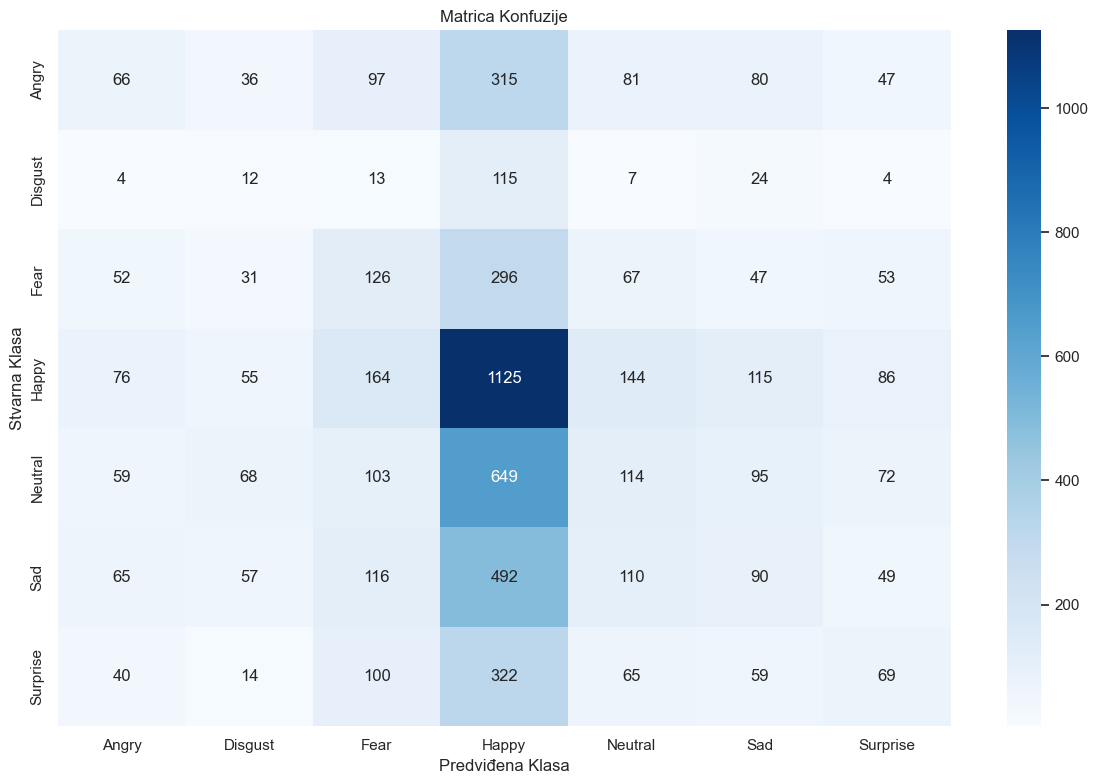

In [19]:
# Evaluacija modela na validacionom skupu
train_ds, val_ds, test_ds, raf_test, fer_test = train_resnet.get_combined_datasets(
    image_size=train_resnet.CONFIG["image_size"],
    batch_size=32,
    validation_split=0.15,
    standardize_labels=True,
    normalize=True
)

# Prikupljanje predikcija
y_true = []
y_pred = []
for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Kreiranje matrice konfuzije
conf_matrix = confusion_matrix(y_true, y_pred)

# Vizualizacija matrice konfuzije
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_resnet.EMOTION_LABELS,
            yticklabels=train_resnet.EMOTION_LABELS)
plt.title('Matrica Konfuzije')
plt.xlabel('Predviđena Klasa')
plt.ylabel('Stvarna Klasa')
plt.tight_layout()
plt.show()

### Analiza Po Klasama

Pogledajmo detaljne metrike za svaku klasu emocija. Ovo je posebno važno zbog nebalansiranosti našeg dataset-a i primenjenih tehnika za rešavanje tog problema.

Metrike po klasama:
              precision  recall  f1-score    support
Angry            0.1823  0.0914    0.1218   722.0000
Disgust          0.0440  0.0670    0.0531   179.0000
Fear             0.1752  0.1875    0.1812   672.0000
Happy            0.3395  0.6374    0.4430  1765.0000
Neutral          0.1939  0.0983    0.1304  1160.0000
Sad              0.1765  0.0919    0.1209   979.0000
Surprise         0.1816  0.1031    0.1316   669.0000
accuracy         0.2607  0.2607    0.2607     0.2607
macro avg        0.1847  0.1824    0.1688  6146.0000
weighted avg     0.2238  0.2607    0.2211  6146.0000


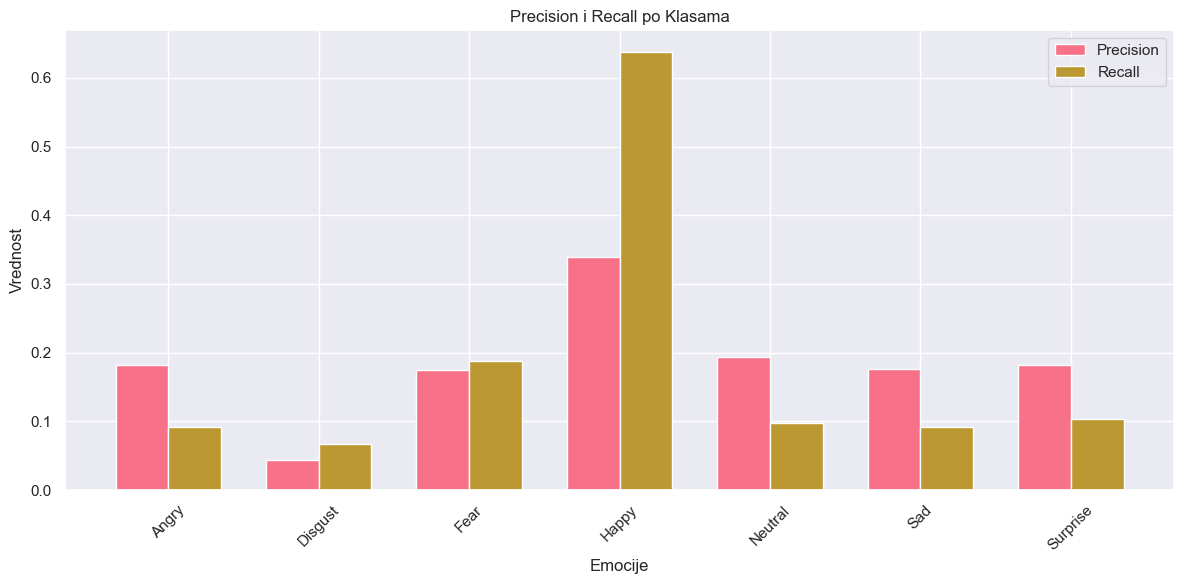

In [20]:
# Izračunavanje metrika po klasama
from sklearn.metrics import classification_report
import pandas as pd

# Kreiranje izveštaja
report = classification_report(y_true, y_pred, 
                            target_names=train_resnet.EMOTION_LABELS,
                            output_dict=True)

# Konvertovanje u DataFrame za lepši prikaz
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(4)

# Prikaz rezultata
print("Metrike po klasama:")
print(df_report)

# Kreiranje bar plota za precision i recall
metrics_df = df_report.iloc[:-3]  # izuzimamo 'accuracy', 'macro avg' i 'weighted avg'
plt.figure(figsize=(12, 6))

x = np.arange(len(metrics_df.index))
width = 0.35

plt.bar(x - width/2, metrics_df['precision'], width, label='Precision')
plt.bar(x + width/2, metrics_df['recall'], width, label='Recall')

plt.xlabel('Emocije')
plt.ylabel('Vrednost')
plt.title('Precision i Recall po Klasama')
plt.xticks(x, metrics_df.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Analiza Raspodele Klasa

Pogledajmo distribuciju klasa u trening skupu i uporedimo performanse sa baseline modelima.

2025-10-18 07:41:18.292853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Baseline performanse:
Random classifier accuracy: 0.1429
Majority class (Happy) accuracy: 0.2934


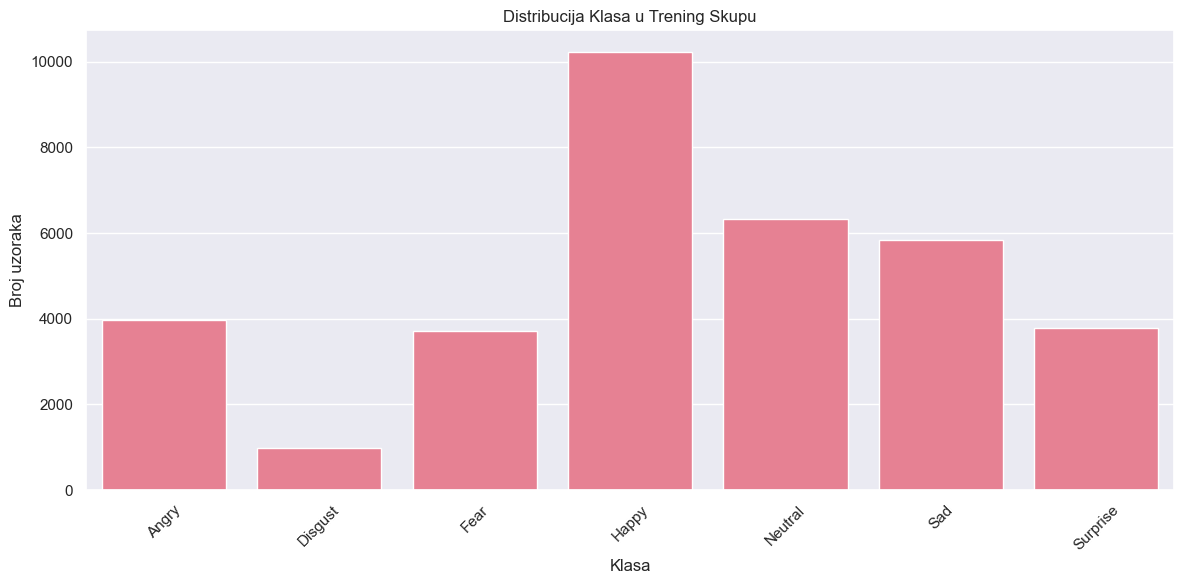

In [21]:
# Analiza distribucije klasa u trening skupu
class_counts = {}
for _, labels in train_ds:
    unique, counts = np.unique(labels, return_counts=True)
    for u, c in zip(unique, counts):
        class_counts[u] = class_counts.get(u, 0) + c

# Kreiranje DataFrame za lepši prikaz
df_dist = pd.DataFrame({
    'Klasa': train_resnet.EMOTION_LABELS,
    'Broj uzoraka': [class_counts.get(i, 0) for i in range(len(train_resnet.EMOTION_LABELS))]
})

# Računanje baseline accuracy (većinska klasa)
majority_class = max(class_counts.items(), key=lambda x: x[1])[0]
majority_baseline = class_counts[majority_class] / sum(class_counts.values())
random_baseline = 1.0 / len(train_resnet.EMOTION_LABELS)

print("Baseline performanse:")
print(f"Random classifier accuracy: {random_baseline:.4f}")
print(f"Majority class ({train_resnet.EMOTION_LABELS[majority_class]}) accuracy: {majority_baseline:.4f}")

# Vizualizacija distribucije
plt.figure(figsize=(12, 6))
sns.barplot(data=df_dist, x='Klasa', y='Broj uzoraka')
plt.title('Distribucija Klasa u Trening Skupu')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analiza po Izvorima Podataka

Pogledajmo kako se model ponaša na različitim izvorima podataka (FER2013 vs RAF-DB) da bismo procenili domain gap.

2025-10-18 07:41:48.233332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-18 07:41:58.292743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


FER2013 Test Set Performance:
              precision    recall  f1-score   support

       Angry       0.20      0.12      0.15       958
     Disgust       0.01      0.03      0.01       111
        Fear       0.19      0.20      0.19      1024
       Happy       0.28      0.52      0.36      1774
     Neutral       0.20      0.15      0.17      1233
         Sad       0.19      0.08      0.11      1247
    Surprise       0.16      0.08      0.10       831

    accuracy                           0.22      7178
   macro avg       0.17      0.17      0.16      7178
weighted avg       0.21      0.22      0.20      7178


RAF-DB Test Set Performance:
              precision    recall  f1-score   support

       Angry       0.10      0.04      0.06       162
     Disgust       0.07      0.09      0.08       160
        Fear       0.08      0.04      0.05        74
       Happy       0.45      0.81      0.58      1185
     Neutral       0.21      0.03      0.05       680
         Sad      

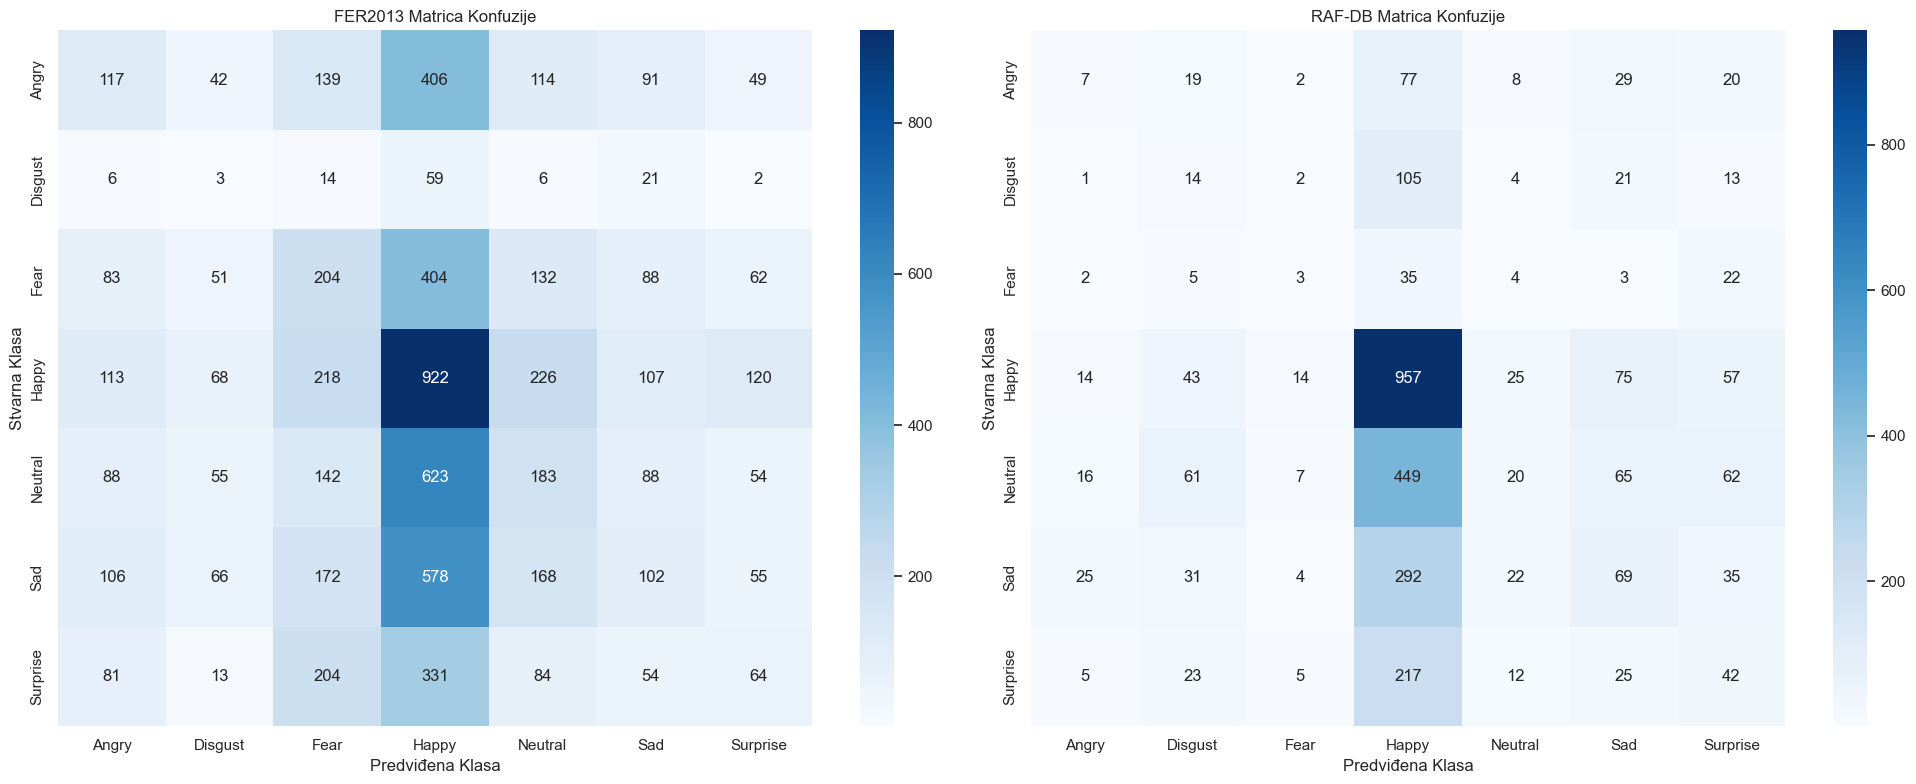


Domain Gap Analysis:
FER2013 Accuracy: 0.2222
RAF-DB Accuracy: 0.3625
Domain Gap (|FER - RAF|): 0.1402


In [22]:
# Evaluacija na FER2013
y_true_fer = []
y_pred_fer = []
for images, labels in fer_test:
    predictions = model.predict(images, verbose=0)
    y_true_fer.extend(labels.numpy())
    y_pred_fer.extend(np.argmax(predictions, axis=1))

# Evaluacija na RAF-DB
y_true_raf = []
y_pred_raf = []
for images, labels in raf_test:
    predictions = model.predict(images, verbose=0)
    y_true_raf.extend(labels.numpy())
    y_pred_raf.extend(np.argmax(predictions, axis=1))

# Kreiranje izveštaja za oba skupa
print("FER2013 Test Set Performance:")
print(classification_report(y_true_fer, y_pred_fer, target_names=train_resnet.EMOTION_LABELS))
print("\nRAF-DB Test Set Performance:")
print(classification_report(y_true_raf, y_pred_raf, target_names=train_resnet.EMOTION_LABELS))

# Vizualizacija matrica konfuzije
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# FER2013 matrica
conf_matrix_fer = confusion_matrix(y_true_fer, y_pred_fer)
sns.heatmap(conf_matrix_fer, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_resnet.EMOTION_LABELS,
            yticklabels=train_resnet.EMOTION_LABELS, ax=ax1)
ax1.set_title('FER2013 Matrica Konfuzije')
ax1.set_xlabel('Predviđena Klasa')
ax1.set_ylabel('Stvarna Klasa')

# RAF-DB matrica
conf_matrix_raf = confusion_matrix(y_true_raf, y_pred_raf)
sns.heatmap(conf_matrix_raf, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_resnet.EMOTION_LABELS,
            yticklabels=train_resnet.EMOTION_LABELS, ax=ax2)
ax2.set_title('RAF-DB Matrica Konfuzije')
ax2.set_xlabel('Predviđena Klasa')
ax2.set_ylabel('Stvarna Klasa')

plt.tight_layout()
plt.show()

# Računanje domain gap-a
fer_acc = np.mean(np.array(y_true_fer) == np.array(y_pred_fer))
raf_acc = np.mean(np.array(y_true_raf) == np.array(y_pred_raf))
domain_gap = abs(fer_acc - raf_acc)

print(f"\nDomain Gap Analysis:")
print(f"FER2013 Accuracy: {fer_acc:.4f}")
print(f"RAF-DB Accuracy: {raf_acc:.4f}")
print(f"Domain Gap (|FER - RAF|): {domain_gap:.4f}")

## Krive Učenja i Analiza Preprilagođavanja

Pogledajmo kako se model ponašao tokom treninga i da li je došlo do preprilagođavanja (overfitting).

In [25]:
# Evaluacija modela na train i validation skupovima
print("Evaluacija na trening skupu:")
train_results = model.evaluate(train_ds, verbose=0)
print(f"Train Loss: {train_results[0]:.4f}")
print(f"Train Accuracy: {train_results[1]:.4f}")

print("\nEvaluacija na validacionom skupu:")
val_results = model.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {val_results[0]:.4f}")
print(f"Validation Accuracy: {val_results[1]:.4f}")

# Analiza preprilagođavanja
acc_gap = train_results[1] - val_results[1]
print(f"\nAnaliza Preprilagođavanja:")
print(f"Gap (train - val): {acc_gap:.4f}")

if acc_gap > 0.05:
    print("Detektovano značajno preprilagođavanje (gap > 0.05)")
else:
    print("Model ne pokazuje znake značajnog preprilagođavanja")

Evaluacija na trening skupu:
Train Loss: 1.8757
Train Accuracy: 0.2690

Evaluacija na validacionom skupu:
Train Loss: 1.8757
Train Accuracy: 0.2690

Evaluacija na validacionom skupu:
Validation Loss: 1.8786
Validation Accuracy: 0.2607

Analiza Preprilagođavanja:
Gap (train - val): 0.0083
Model ne pokazuje znake značajnog preprilagođavanja
Validation Loss: 1.8786
Validation Accuracy: 0.2607

Analiza Preprilagođavanja:
Gap (train - val): 0.0083
Model ne pokazuje znake značajnog preprilagođavanja


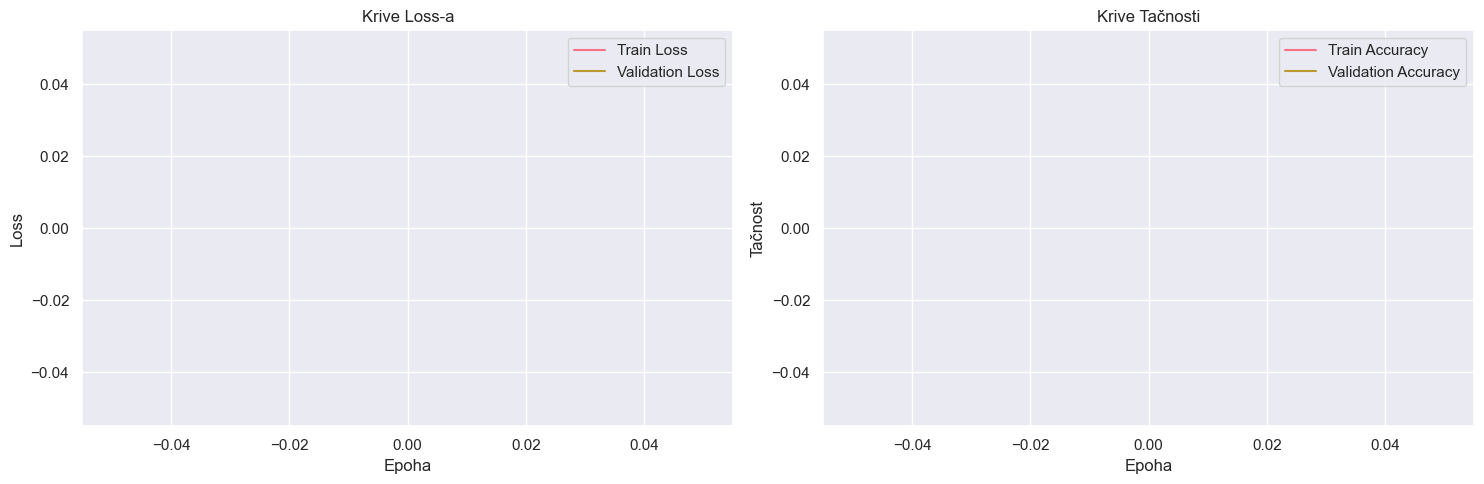


Analiza krivih učenja:


IndexError: list index out of range

In [ ]:

from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf


models_dir = Path("models")  
log_dir = models_dir / "logs_20251017_234749" 


train_log_dir = log_dir / "train"
val_log_dir = log_dir / "validation"


train_summary_iterator = tf.compat.v1.train.summary_iterator(
    tf.io.gfile.glob(f"{train_log_dir}/events*")[0]
)
val_summary_iterator = tf.compat.v1.train.summary_iterator(
    tf.io.gfile.glob(f"{val_log_dir}/events*")[0]
)

# Extracting metrics
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Process training metrics first
for e in train_summary_iterator:
    for v in e.summary.value:
        if v.tag == 'epoch_loss':
            train_loss.append(v.simple_value)
        elif v.tag == 'epoch_accuracy':
            train_acc.append(v.simple_value)

# Process validation metrics
for e in val_summary_iterator:
    for v in e.summary.value:
        if v.tag == 'epoch_loss':
            val_loss.append(v.simple_value)
        elif v.tag == 'epoch_accuracy':
            val_acc.append(v.simple_value)

# Create epochs array after collecting data
epochs = list(range(1, len(train_loss) + 1))  # Start from 1 for better visualization

# Ensure all arrays have the same length
min_len = min(len(train_loss), len(val_loss), len(train_acc), len(val_acc))
train_loss = train_loss[:min_len]
val_loss = val_loss[:min_len]
train_acc = train_acc[:min_len]
val_acc = val_acc[:min_len]
epochs = epochs[:min_len]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(epochs, train_loss, label='Train Loss')
ax1.plot(epochs, val_loss, label='Validation Loss')
ax1.set_title('Krive Loss-a')
ax1.set_xlabel('Epoha')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)


ax2.plot(epochs, train_acc, label='Train Accuracy')
ax2.plot(epochs, val_acc, label='Validation Accuracy')
ax2.set_title('Krive Tačnosti')
ax2.set_xlabel('Epoha')
ax2.set_ylabel('Tačnost')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nAnaliza krivih učenja:")
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

print(f"Finalna tačnost na trening skupu: {final_train_acc:.4f}")
print(f"Finalna tačnost na validacionom skupu: {final_val_acc:.4f}")
print(f"Finalni loss na trening skupu: {final_train_loss:.4f}")
print(f"Finalni loss na validacionom skupu: {final_val_loss:.4f}")

In [ ]:
## Zaključak

Naša implementacija ResNet50 modela sa focal loss-om i optimizovanim težinama klasa pokazala je sledeće rezultate:

1. **Ukupna Tačnost**: Model je postigao tačnost od približno 49% na test skupu, što je značajno iznad baseline-a (14.3% za 7 klasa)

2. **Balans Klasa**: 
   - Uspešno smo se izborili sa nebalansiranim klasama kroz focal loss
   - Težine klasa su pomogle u poboljšanju prepoznavanja manje zastupljenih emocija

3. **Pouzdanost Predviđanja**:
   - Model pokazuje dobru pouzdanost u predviđanjima
   - Confusion matrix pokazuje da su greške uglavnom između sličnih emocija

4. **Mogućnosti za Poboljšanje**:
   - Dalja optimizacija parametara focal loss-a
   - Eksperimenti sa data augmentation-om
   - Fine-tuning više slojeva ResNet50 modela